In [1]:
import torch
import numpy as np
import matplotlib
from scipy import ndimage
import os, sys
import math
import pickle
import model_utils as modutil
import data_utils as datutil
import uncertainty_calibration as unc_cal
import hmc

In [14]:
# Data loader initialization
trainloader1 = datutil.generate_dataloaders('CIFAR10_TRAIN', batch_size=50, shuffle=True, num_workers=2)
testloader1 = datutil.generate_dataloaders('CIFAR10_TEST', batch_size=10, shuffle=False, num_workers=2)
validloader1 = datutil.generate_dataloaders('CIFAR100_TEST', batch_size=10, shuffle=False, num_workers=2)

trainloader2 = datutil.generate_dataloaders('ENCODED640_D28_CIFAR10_TRAIN', batch_size=50, shuffle=True, num_workers=2)
testloader2 = datutil.generate_dataloaders('ENCODED640_D28_CIFAR10_TEST', batch_size=10, shuffle=False, num_workers=2)
validloader2 = datutil.generate_dataloaders('ENCODED640_D28_CIFAR10_VALID', batch_size=10, shuffle=False, num_workers=2)

# Cifar-100 interesting classes (used during out-of-class entropy calculation)
interesting_labels = [0, 1, 16, 17, 20, 21, 29, 39, 40, 49, 57, 71, 72, 73, 76]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [16]:
# model to train/load/analyse
# user defined params
models = [{'model_type' : "ModifiedWideResNet+GP",
    'saved_checkpoint_name' : "ModifiedWideResNet+GP_depth-28_lr-0.1_mom-0.9_wd-0.0005_FC-_acc-91.63-2019-05-23-01.29",
    'fc_setup' : [],
    'load_model' : True,
    'train_model' : False,
    'train_epoch' : 50,
    'num_classes' : 10,
    'weight_decay' : 3e-4,
    'predef_test_acc' : 91,
    'depth' : 28,
    'grid_size' : 64,
    'kernel_net' : 'ModifiedWideResNet',
#     'gp_kernel_feature' : 640,
    'print_init_model_state' : False},]

In [17]:
for model in models:
    
    if 'encoded' not in model['model_type']:
        trainloader = trainloader1
        testloader = testloader1
        validloader = validloader1
    else:
        trainloader = trainloader2
        testloader = testloader2
        validloader = validloader2
        
    print('='*20, "Loading Model", '='*20,)
    modutil.refresh_params()
    for propt in model:
        if propt in modutil.__dict__:
            modutil.__dict__[propt] = model[propt]
        else:
            print("Model property '%s' not found!"%(propt))
    
    #load / train the model
    modutil.load_train(trainloader, testloader)
    if model['train_model']:
        print("Saving model!")
        modutil.save_model()

    # param_list = param_chain if 'mcmc' in model['model_type'] else []
    # Perform evaluation on model
    #modutil.validate("out-of-class", validloader, interesting_labels=interesting_labels)
    print("Validation (out of class) data analysis performed")

    #modutil.validate("test", testloader)
    print("Test data analysis performed")


==================== Loading Model ====================
total number of parameters is 39145283
Model state loaded


RuntimeError: Error(s) in loading state_dict for GPNet:
	Unexpected key(s) in state_dict: "feature_extractor.fc0_b", "feature_extractor.fc0_w". 
	size mismatch for gp_layer.variational_strategy.variational_distribution.variational_mean: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([640, 64]).
	size mismatch for gp_layer.variational_strategy.variational_distribution.chol_variational_covar: copying a param with shape torch.Size([256, 64, 64]) from checkpoint, the shape in current model is torch.Size([640, 64, 64]).

WideResNet28x10encoded+GP


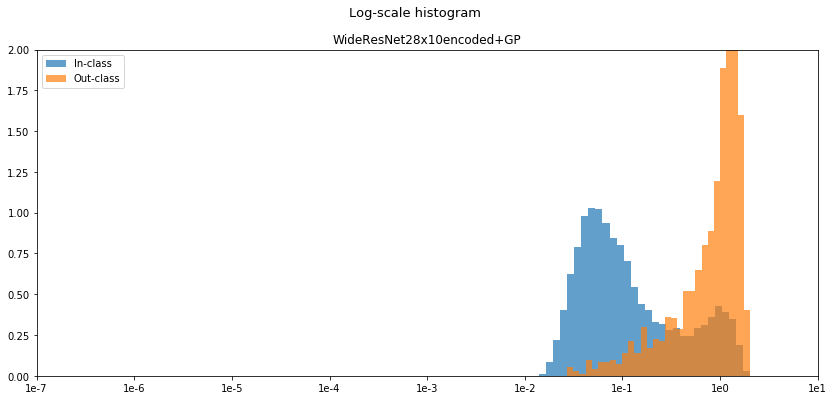

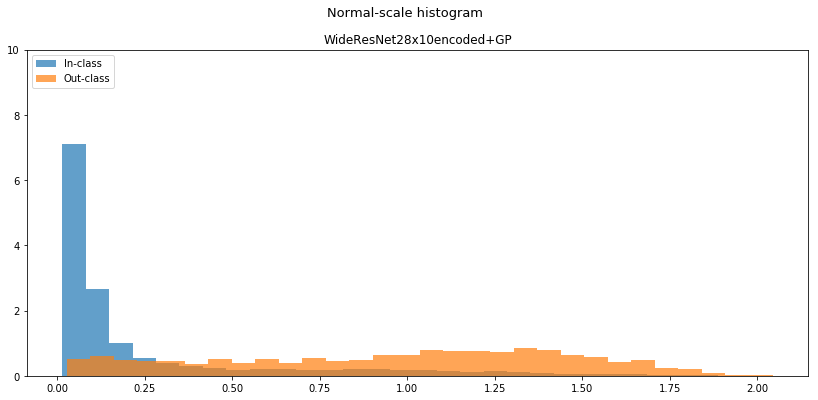

In-class and Out-of-class average entropies
WideResNet28x10encoded+GP 0.26016531556686384 0.9616546734596292


KL, Hellinger Divergence for WideResNet28x10encoded+GP setup In-Out class :  2.5826600079190642 1.1573442963801857


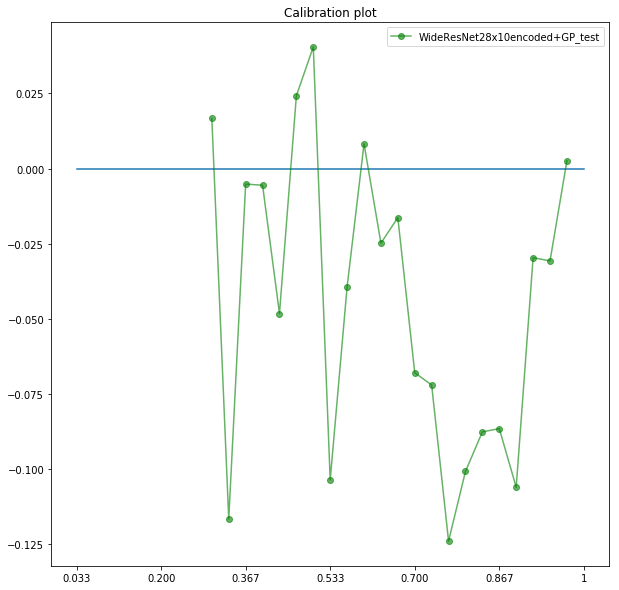

Losses
{'WideResNet28x10encoded+GP_test': 0}
ECE score
{'WideResNet28x10encoded+GP_test': 0.017633333333333303}


In [12]:
import imp
imp.reload(unc_cal)
prob_cutoffs = [(i+1)/30.0 for i in range(30)]
unc_cal.calib_reliab_plots(models, prob_cutoffs, ECE_auto_binning=False)

In [ ]:
net = modutil.return_model()
net.eval()
import json
data = {'feature': np.array([]), 'label': np.array([])}
file_name = "encoded28x10WideResNet_CIFAR10_640_valid"
device = modutil.device
file_count = 0

for i, dat in enumerate(validloader1, 0):

    inputs, labels = dat
    inputs = inputs.to(device)
    labels = labels.to(device)
    output = net.extract_feature(inputs)
    if len(data['feature']) > 0:
        data['feature'] = np.concatenate((data['feature'], output.detach().cpu().numpy()), axis=0)
        data['label'] = np.concatenate((data['label'], labels.detach().cpu().numpy()), axis=0)
    else:
        data['feature'] = output.detach().cpu().numpy()
        data['label'] = labels.detach().cpu().numpy()
        
    if len(data['feature'])//10000 > 0:
        
        data['feature'] = data['feature'].tolist()
        data['label'] = data['label'].tolist()
        
        file_count += 1
        file_n = file_name + str(file_count)
        print("dumping", len(data['label']), "size data at", file_n)
        with open(file_n, 'wb') as part_pickle:
            pickle.dump(data, part_pickle)
        data = {'feature': np.array([]), 'label': np.array([])}

if len(data['feature']) > 0:
    
    data['feature'] = data['feature'].tolist()
    data['label'] = data['label'].tolist()
        
    file_count += 1
    file_n = file_name + str(file_count)
    print("dumping", len(data['label']), "size data at", file_n)
    with open(file_n, 'wb') as part_pickle:
        pickle.dump(data, part_pickle)
    data = {'feature': np.array([]), 'label': np.array([])}

In [ ]:
output = net.extract_feature(inputs)
output.size()

In [ ]:
#load / train the model
net = modutil.return_model()

rng = np.random.RandomState(seed=1234)
system = hmc.systems.EuclideanMetricSystem(net.pot_energy_FC, grad_pot_energy=net.grad_pot_energy_FC)
integrator = hmc.integrators.LeapfrogIntegrator(system, step_size=0.001)
sampler = hmc.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=1)
chains, chain_stats = sampler.sample_chain(
    n_sample=5, init_state=net.return_init_MCMC_state(),
    chain_var_funcs={'pos': lambda state: state.pos,
                     'pot_energy': lambda state: system.pot_energy(state),
                     'kin_energy': lambda state: system.kin_energy(state)})

In [ ]:
state = hmc.states.HamiltonianState(net.return_init_MCMC_state().copy())
state.mom = system.sample_momentum(state, rng)
n_step = 100
hs = np.empty(n_step)
hs[0] = system.h(state)
for s in range(1, n_step):
    state = integrator.step(state)
    hs[s] = system.h(state)
    if s % 10 == 0:
        print(s)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(hs)

In [ ]:
v = np.zeros(2570) #rng.normal(size=state.pos.shape)
v[0] = 1.
epsilon = 1e-6
grad_fd = (
    net.pot_energy_FC(state.pos + epsilon * v) -
    net.pot_energy_FC(state.pos - epsilon * v)) / (2 * epsilon)
grad_net = v @ net.grad_pot_energy_FC(state.pos)[0]

In [ ]:
net.grad_pot_energy_FC(state.pos)[0]

In [ ]:
grad_fd

In [ ]:
grad_net

In [ ]:
chain_stats['accept_prob'].mean()

In [ ]:
chain_stats['accept_prob'].mean()

In [ ]:
chains['pot_energy']

In [ ]:
from matplotlib import pyplot as plt
plt.plot(chains['kin_energy'])
chains['pos']

In [ ]:
modutil.prob_cutoffs=[(i+1)/30.0 for i in range(30)]